In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

#### Here we reproduce the results from *Identifying and Correcting Label Bias in Machine Learning* 
[\[Jiang and Nachum 2019\]](https://arxiv.org/pdf/1901.04966.pdf)

The code from the authors could be found [here](https://github.com/google-research/google-research/blob/master/label_bias/)

In [2]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from joblib import Memory, Parallel, delayed
location = './cachedir'
memory = Memory(location, verbose=0)

@memory.cache
def get_adult(random_state=42):
    # Load Adult Census data

    df = pd.read_csv(
    "https://www.openml.org/data/get_csv/1595261/adult-census.csv")
    target_name = "class"
    target = df[target_name].to_numpy()
    target = target == ' >50K'

    protected_group = (df['sex']==' Female')

    data = df.drop(columns=[target_name, "fnlwgt"])

    data_train, data_test, target_train, target_test,\
        protected_train, protected_test = train_test_split(
        data, target, protected_group, random_state=random_state)

    # preprocessing steps
    binary_encoding_columns = ['sex']
    one_hot_encoding_columns = [
        'workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'native-country']
    scaling_columns = [
        'age', 'education-num', 'hours-per-week', 'capital-gain',
        'capital-loss']

    preprocessor = ColumnTransformer([
        ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
        ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'),
        one_hot_encoding_columns),
        ('standard-scaler', StandardScaler(), scaling_columns)])

    data_train = preprocessor.fit_transform(data_train)
    data_test = preprocessor.transform(data_test)

    return data_train, data_test, target_train, target_test,\
           protected_train, protected_test

X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=42)

In [3]:
from fairness import plot_confusion_matrix

In [4]:
# Define our model once and for all
from sklearn.linear_model import LogisticRegression, SGDClassifier
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr = SGDClassifier(loss="log", penalty="l2", alpha=5e-4,
                   validation_fraction=0.2, random_state=0,
                   early_stopping=True, n_iter_no_change=5, tol=1e-3)

In [5]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Error on test set =', 1-lr.score(X_test, y_test))

Error on test set = 0.14200311194824333


## 1. "Equal Opportunity" Fairness 

There is severals way to define the fairness, here we will focus on one simple notion:  
A classifier has **Equal opportunity** [Hardt et al., 2016]() if its true positive rates are the same on protected groups and on all of X

Now if we want to check if the predictions of our model is fair with respect to the protected group, let's examine the confusion matrix for both the protected group and the full data.

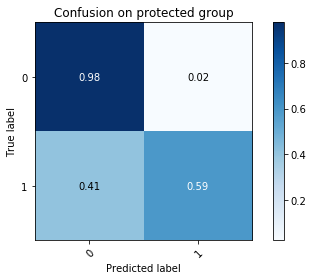

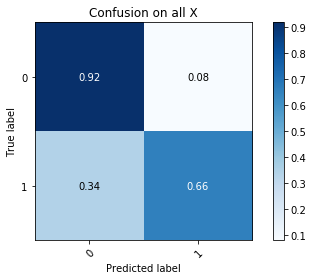

In [6]:
plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

We clearly see that the **True Positive Rate** on the protected group (of 0.59) is **lower** than on all X (0.66).  
So our classifier is bias w.r.t. the protected group. That violate the *Equal opportunity* fairness.  

In [7]:
def equal_opportunity_violation(y_pred, y_test, protected_group):
    """ Compute the fairness violation w.r.t. the protected group 
    
    Equal opportunity compares true positive rates
    """

    # Positive true label
    P_true_X = sum(y_test) 
    P_true_pg = sum(y_test & protected_group) 
    # True Positif
    TP_X = sum(y_pred & y_test) 
    TP_pg = sum(y_pred & protected_group & y_test)    

    diff_TPR = TP_pg / P_true_pg - TP_X / P_true_X
    return diff_TPR

equal_opportunity_violation(y_pred, y_test, protected_test)

-0.0658839355269426

## 2. Correct the fairness violation by reweighting / sample_weight

If we assume that `y` observed is biased according to (one or severals) protected groups, we could reweigth higher sample (in the protected group) with positive label

lambda_star:  0.5882352941176472
CPU times: user 10.8 s, sys: 253 ms, total: 11 s
Wall time: 10.8 s


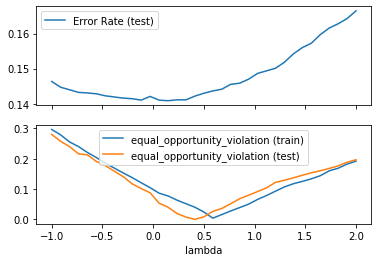

In [8]:
%%time

def reweigth_samples(lambda_, protected_group, y_bias):
    # Compute the reweighting w.r.t the protected group
    
    w_tilde = np.exp(lambda_ * protected_group)
    w = np.array(w_tilde / (1 + w_tilde) * y_bias +\
                 1 / (1 + w_tilde) * (1 - y_bias))
    return w
    
l_lambda = np.linspace(-1, 2, 35)
l_fairness_violation_train = []
l_fairness_violation_test = []
l_err_test = []
for lambda_ in l_lambda:
    
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)

    train_violation = equal_opportunity_violation(
        lr.predict(X_train), y_train, protected_train)
    test_violation = equal_opportunity_violation(
        lr.predict(X_test), y_test, protected_test)
    l_fairness_violation_train.append(train_violation)
    l_fairness_violation_test.append(test_violation)
    l_err_test.append(1-lr.score(X_test, y_test))
   
    # Note that an iterative approach is possible to converge to lambda_star:
    # if we set each time `lambda_ = lambda_ - train_violation`

lambda_star = l_lambda[np.argmin(np.abs(l_fairness_violation_train))]
print('lambda_star: ', lambda_star)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(l_lambda, l_err_test, label='Error Rate (test)')
ax0.legend()
ax1.plot(l_lambda, np.abs(l_fairness_violation_train),
         label='equal_opportunity_violation (train)')
ax1.plot(l_lambda, np.abs(l_fairness_violation_test),
         label='equal_opportunity_violation (test)')
plt.xlabel('lambda')
plt.legend()

Error on test set = 0.14364097944476295


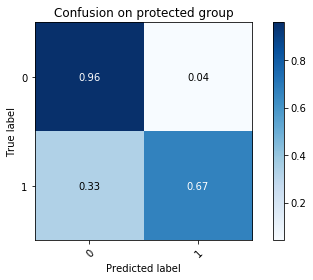

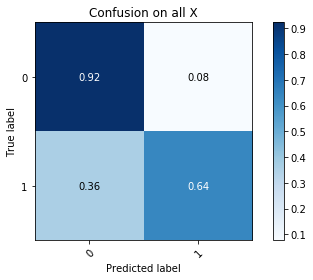

In [9]:
# Giving lambda_star, let's examine the confusion matrix obtain by reweighting samples.

w_star = reweigth_samples(lambda_star, protected_train, y_train)
lr.fit(X_train, y_train, sample_weight=w_star)
print('Error on test set =', 1-lr.score(X_test, y_test))
y_pred = lr.predict(X_test)

plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X');

By reweighting, the true positif rate is equivalent (up to some standard deviation) on the protected group and on all sample. 
Our classfier is more fair.

## 3. With generated data
Generated data allow us to acces to `y_true` (which is usualy unobserved)

In [10]:
from sklearn.datasets import make_classification

def get_generated_rnd_data(n_samples=20000, random_state=1, n_features=20):
    # generate artificial data    
    
    np.random.seed(random_state)
    X, y_true = make_classification(n_samples=n_samples,
                                    random_state=random_state, n_features=n_features) 
    protected_group = X[:,0] > 0 
    
    # Some positif examples on protected group might be biased.
    protected_and_positif = np.logical_and(y_true>0, protected_group)
    y_bias = y_true.copy()
    y_bias[protected_and_positif] = np.random.binomial(1, .6, size = sum(protected_and_positif))

    return train_test_split(X, y_true, y_bias,
                            protected_group,
                            random_state=random_state)


X_train, X_test,\
y_true_train, y_true_test,\
y_bias_train, y_bias_test,\
protected_train, protected_test = get_generated_rnd_data()
# protected_train, protected_test = get_generated_bias_data(lambda0=1.2)

y_train, y_test = y_bias_train, y_bias_test

In [11]:
lr.fit(X_train, y_bias_train)
print('Error on bias test set =', 1-lr.score(X_test, y_bias_test))
print('Error on true test set =', 1-lr.score(X_test, y_true_test))
y_pred = lr.predict(X_test)

Error on bias test set = 0.17120000000000002
Error on true test set = 0.12280000000000002


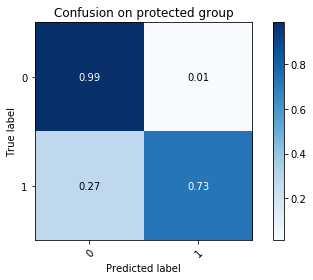

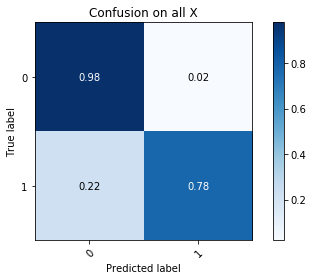

In [12]:
plot_confusion_matrix(y_true_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_true_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

Here again, TPR is not equivalent.

CPU times: user 47.2 s, sys: 43.6 s, total: 1min 30s
Wall time: 12.3 s


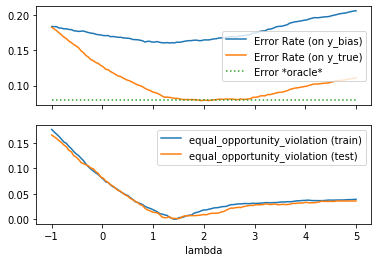

In [13]:
%%time

l_lambda = np.linspace(-1, 5, 125)
l_fairness_violation_train = []
l_fairness_violation_test = []
l_fairness_violation_test_true = []
l_err_test = []
l_true_err = []
for lambda_ in l_lambda:  # range(100): #2.507586
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)

    train_violation = equal_opportunity_violation(
        lr.predict(X_train), y_train, protected_train)
    test_violation = equal_opportunity_violation(
        lr.predict(X_test), y_test, protected_test)
    test_violation_true = equal_opportunity_violation(
        lr.predict(X_test), y_true_test, protected_test)
    l_fairness_violation_train.append(train_violation)
    l_fairness_violation_test.append(test_violation)
    l_fairness_violation_test_true.append(test_violation)
    l_err_test.append(1-lr.score(X_test, y_test))
    l_true_err.append(1-lr.score(X_test, y_true_test))



fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(l_lambda, l_err_test, label = 'Error Rate (on y_bias)')
ax0.plot(l_lambda, l_true_err, label = 'Error Rate (on y_true)')
lr.fit(X_train, y_true_train)
err_oracle = 1-lr.score(X_test, y_true_test)
ax0.plot(l_lambda, [err_oracle] * len(l_lambda), ':', label='Error *oracle*')
ax0.legend()

ax1.plot(l_lambda, np.abs(l_fairness_violation_train),
         label='equal_opportunity_violation (train)')
ax1.plot(l_lambda, np.abs(l_fairness_violation_test),
         label='equal_opportunity_violation (test)')
plt.xlabel('lambda')
plt.legend()

lambda_star:  1.4193548387096775


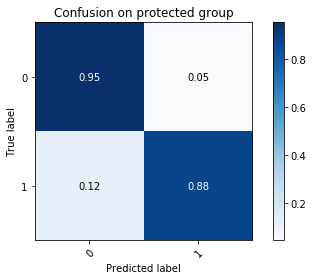

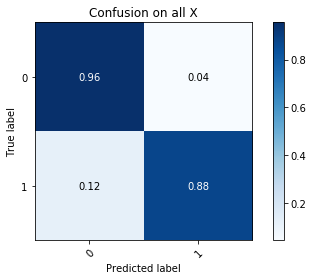

In [14]:
lambda_star = l_lambda[np.argmin(np.abs(l_fairness_violation_train))]
print('lambda_star: ', lambda_star)
w_star = reweigth_samples(lambda_star, protected_train, y_train)
lr.fit(X_train, y_bias_train, sample_weight=w_star)
y_pred_star = lr.predict(X_test)

plot_confusion_matrix(y_true_test[protected_test], y_pred_star[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_true_test, y_pred_star, ['0', '1'], normalize=True, title='Confusion on all X')

CPU times: user 55.5 s, sys: 51.8 s, total: 1min 47s
Wall time: 14.4 s


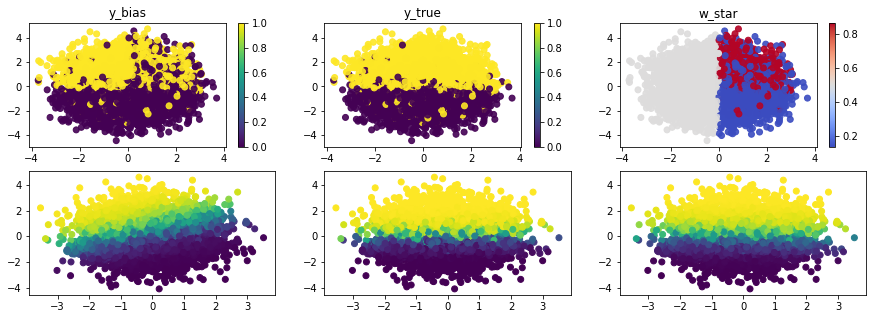

In [15]:
%%time

### special cell for plotting a visu

X_train, X_test,\
y_true_train, y_true_test,\
y_bias_train, y_bias_test,\
protected_train, protected_test = get_generated_rnd_data(n_features=5, random_state=6)
y_train, y_test = y_bias_train, y_bias_test

lambda_ = 0
ll = []
for _ in range(200): 
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)
    train_violation = equal_opportunity_violation(
        lr.predict(X_train), y_train, protected_train)
    lambda_ = lambda_ - train_violation
    ll.append(lambda_)

lambda_star = lambda_

plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
plt.title('y_bias')
plt.scatter(X_train[:,0], X_train[:,1], c=y_bias_train, alpha=.9)
plt.colorbar()
plt.subplot(2,3,2)
plt.title('y_true')
plt.scatter(X_train[:,0], X_train[:,1], c=y_true_train, alpha=.9)
plt.colorbar()
plt.subplot(2,3,4)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])
plt.subplot(2,3,5)
lr.fit(X_train, y_true_train)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])

plt.subplot(2,3,3)
plt.title('w_star')
w_star = reweigth_samples(lambda_star, protected_train, y_train)
lr.fit(X_train, y_train, sample_weight=w_star)
plt.scatter(X_train[:,0], X_train[:,1], c=w_star, cmap='coolwarm', alpha=.9)
plt.colorbar()
plt.subplot(2,3,6)
y_pred = lr.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=lr.predict_proba(X_test)[:,1])

0
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 1
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 2
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 4
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 5
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 6
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 7
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 8
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 9
-1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 

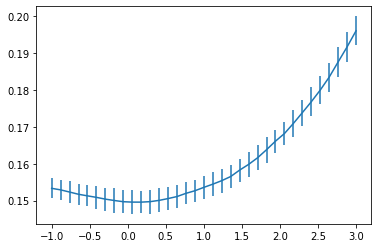

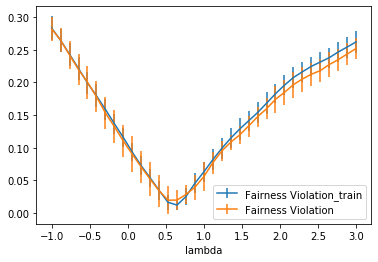

In [20]:
## STD for plot

ll_fair_train, ll_fair, ll_score = [], [], []
for random_state in range(10):
    print(random_state)
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)
    
    lambda_ = 0
    lr.fit(X_train, y_train)

    l_lambda = []
    l_delta = []
    l_score_test_err = []
    l_fairness_violation = []
    l_fairness_violation_train = []
    for t in np.linspace(-1,3, 35):  # range(100): #2.507586
        print(int(t), end=' ')
    #     delta = fairness_violation(lr.predict(X_train), y_train,
    #                                protected_train, notion='demographic_parity')
    #     l_delta.append(delta)
    #     lambda_ = lambda_ - delta
        lambda_ = t
        l_lambda.append(lambda_)
        w = reweigth_samples(lambda_, protected_train, y_train)
        lr.fit(X_train, y_train, sample_weight=w)
        l_score_test_err.append(1-lr.score(X_test, y_test))
        l_fairness_violation_train.append(equal_opportunity_violation(lr.predict(X_train), y_train,
                                   protected_train)) 
        l_fairness_violation.append(equal_opportunity_violation(lr.predict(X_test), y_test,
                                   protected_test)) 
    ll_fair.append(l_fairness_violation)
    ll_fair_train.append(l_fairness_violation_train)
    ll_score.append(l_score_test_err)
    
plt.errorbar(l_lambda, np.mean(ll_score, axis=0), yerr=np.std(ll_score, axis=0), label = 'Error Rate')
plt.figure()
plt.errorbar(l_lambda, np.mean(np.abs(ll_fair_train), axis=0), yerr=np.std(np.abs(ll_fair_train), axis=0), label = 'Fairness Violation_train')
plt.errorbar(l_lambda, np.mean(np.abs(ll_fair), axis=0), yerr=np.std(np.abs(ll_fair), axis=0), label = 'Fairness Violation')
plt.xlabel('lambda')
plt.legend()


In [19]:
### STD for CM
from sklearn.metrics import confusion_matrix

l_cm_protected, l_cm = [], []

for random_state in range(50):
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)

    lr.fit(X_train, y_train)
#     print('Error on test set =', 1-lr.score(X_test, y_test))
    y_pred = lr.predict(X_test)

    cm_protected = confusion_matrix(y_test[protected_test], y_pred[protected_test])
    cm_protected = cm_protected.astype('float') / cm_protected.sum(axis=1)[:, np.newaxis]
    l_cm_protected.append(cm_protected)
    
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    l_cm.append(cm)
    
print('STD for cm_protected :\n', np.asarray(l_cm_protected).std(axis=0))
print('STD for cm:\n', np.asarray(l_cm).std(axis=0))

STD for cm_protected :
 [[0.0042 0.0042]
 [0.0391 0.0391]]
STD for cm:
 [[0.0139 0.0139]
 [0.0461 0.0461]]
